In [1]:
import torch
torch.cuda.is_available()
# torch.__version__


False

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
from pathlib import Path

data_path = Path("dataset_v1/")
data_path

PosixPath('dataset_v1')

In [4]:
import os

def walk_through_dir(dir_path):

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"{len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(data_path)

2 directories and 0 images in dataset_v1
2 directories and 0 images in dataset_v1/test
0 directories and 92 images in dataset_v1/test/aesthetic
0 directories and 92 images in dataset_v1/test/non-aesthetic
2 directories and 0 images in dataset_v1/train
0 directories and 368 images in dataset_v1/train/aesthetic
0 directories and 368 images in dataset_v1/train/non-aesthetic


In [5]:
train_dir = data_path/"train"
test_dir = data_path/"test"

train_dir, test_dir

(PosixPath('dataset_v1/train'), PosixPath('dataset_v1/test'))

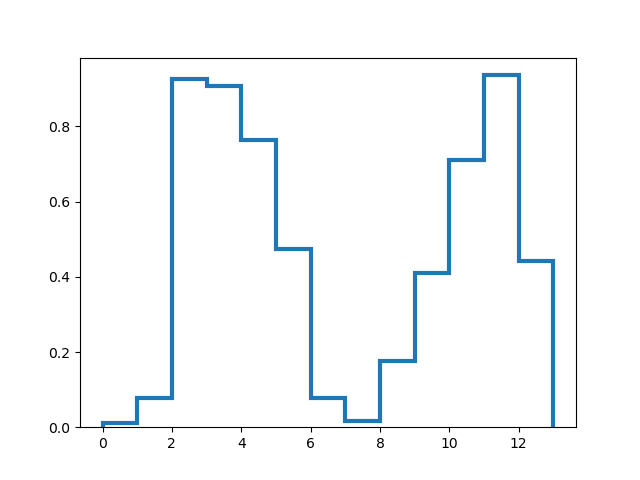

In [6]:
import random
from PIL import Image

image_path_list = list(data_path.glob("*/*/*.png"))
# image_path_list

random_path = random.choice(image_path_list)
random_path

img = Image.open(random_path)
img = img.convert("RGB")
img

In [7]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.axis(False)
img_as_array.shape

(480, 640, 3)

## transfrom img data into tensors

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])




## load image classification data 

In [9]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 736
     Root location: dataset_v1/train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 184
     Root location: dataset_v1/test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

### class names


In [10]:
class_names = train_data.classes

# class names as dictionary
class_dict = train_data.class_to_idx

# dataset length
len(train_data), len(test_data), class_names, class_dict

(736,
 184,
 ['aesthetic', 'non-aesthetic'],
 {'aesthetic': 0, 'non-aesthetic': 1})

In [11]:
train_data

Dataset ImageFolder
    Number of datapoints: 736
    Root location: dataset_v1/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

## CNN 

In [12]:

from torch import nn
class model(nn.Module):
    # TinyVGG model https://poloclub.github.io/cnn-explainer/
    
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*32*32, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [13]:
image, label = train_data[0]
train_data

Dataset ImageFolder
    Number of datapoints: 736
    Root location: dataset_v1/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [14]:
class_names = train_data.classes
class_names

['aesthetic', 'non-aesthetic']

In [15]:
image.shape, label # [color_channels, height, width]

(torch.Size([3, 128, 128]), 0)

### plot data

shape: torch.Size([3, 128, 128])


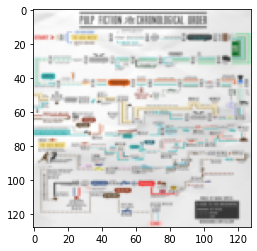

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

image, label = train_data[13]
print(f"shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.show()

### plot data and labels

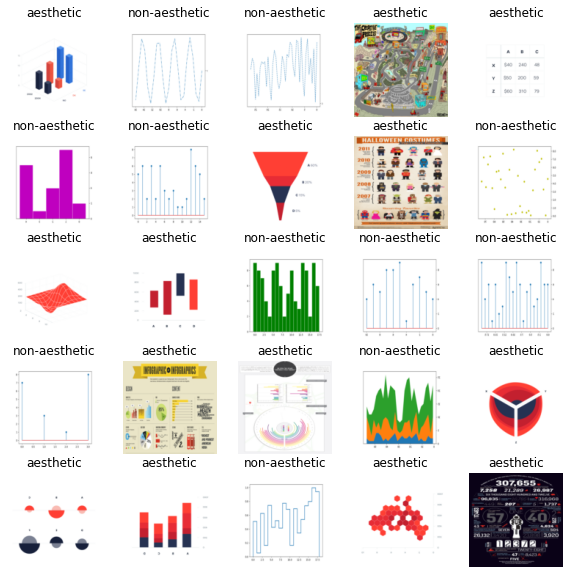

In [17]:
fig = plt.figure(figsize=(10,10))
rows, cols = 5, 5


for i in range(1, rows*cols + 1):
    index = torch.randint(0, len(train_data), size=[1]).item()
    fig.add_subplot(rows, cols, i)
    img, label = train_data[index]
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis(False)

### mini batches of 32 images

In [18]:
from torch.utils.data import DataLoader


BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)



print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length train_dataloader: {len(train_dataloader)}")
print(f"Length test_dataloader: {len(test_dataloader)}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ff4304aeb90>, <torch.utils.data.dataloader.DataLoader object at 0x7ff4304af190>)
Length train_dataloader: 23
Length test_dataloader: 6


In [19]:
train_img_batch, train_labels_batch = next(iter(train_dataloader))
train_img_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

(-0.5, 127.5, 127.5, -0.5)

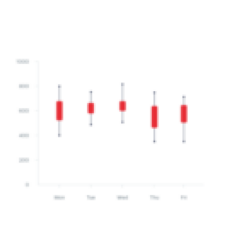

In [20]:
rand = torch.randint(0, len(train_img_batch), size=[1]).item()
img, label = train_img_batch[rand], train_labels_batch[rand]
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)


### model, loss, optimizer...

In [21]:
from torch import nn

def accuracy_fn(y_true, y_pred):
   
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

model_v1 = model(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device=device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v1.parameters(),
                            lr=0.01)

In [22]:
def train(model: torch.nn.Module,
          data_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn,
          device: torch.device=device):
    
    train_loss, train_acc = 0, 0

    model.train()

    for bacth, (X, y) in enumerate(data_loader):

        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.5f}")


def test(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         accuracy_fn,
         device: torch.device=device):
    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}")



In [23]:
from tqdm.auto import tqdm

epochs = 500

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")

    train(model=model_v1,
          data_loader=train_dataloader,
          loss_fn=loss_fn,
          optimizer=optimizer,
          accuracy_fn=accuracy_fn,
          device=device)
    
    test(model=model_v1,
         data_loader=test_dataloader,
         loss_fn=loss_fn,
         optimizer=optimizer,
         accuracy_fn=accuracy_fn,
         device=device)
    
    print("-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+")

S

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.69510 | Train Acc: 2.98913
Test loss: 0.68954 | Test Acc: 55.72917
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 1
Train Loss: 0.69255 | Train Acc: 1.90217
Test loss: 0.68803 | Test Acc: 47.91667
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 2
Train Loss: 0.68969 | Train Acc: 2.58152
Test loss: 0.68019 | Test Acc: 59.37500
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 3
Train Loss: 0.68274 | Train Acc: 2.17391


KeyboardInterrupt: 